# 1D Convolution Layer

- Use HOG, Template and the combined HOG and Template Features to train a 1D Convolution Layer classifier


In [78]:
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import polars as pl

try:
    from sklearnex import patch_sklearn
except ImportError:
    %pip install scikit-learn-intelex
    from sklearnex import patch_sklearn
patch_sklearn()

from feature_utils import normalize_histogram
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

from matplotlib.colors import ListedColormap

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization, LeakyReLU, Activation
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.optimizers import Adam, RMSprop

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# split the data into train, validation and test
from sklearn.model_selection import train_test_split

# pause warnings
import warnings
warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Read Train and Test Parquet Files that contain all the simple and complex features extracted from the images

- Focus on HOG, Template and the combined features as they are the most important ones from our PCA and TSNE analysis

In [6]:
# Read the parquet file, this takes a while. Leave it here
features_file = Path("data/train_features.parquet")
if not features_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

meta_file = Path("data/meta_full.parquet")
if not meta_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

dft = pl.read_parquet(features_file, memory_map=True)
dfm = pl.read_parquet(meta_file, memory_map=True)
dft = dft.join(dfm, on="ClassId")



In [7]:

# Select 200 random samples per class for a total of 8600 samples for model training
samples_per_class = 200
random_seed = 42
pl.set_random_seed(random_seed)
dft = pl.concat(
    [
        x.sample(samples_per_class, with_replacement=False, shuffle=False)
        for x in dft.partition_by("ClassId")
    ]
)
# del dfm

In [79]:
dft.head(1)


id,ClassId,Width,Height,Image,Resolution,Scaled_Meta_Image,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Image,LBP_Hist,HOG_Features,HOG_Image,Template_Pattern,RESNET101,VGG16,Path,ShapeId,ColorId,SignId,Description,Meta_Image,Meta_Width,Meta_Height,Meta_Resolution,Scaled_Meta_Width,Scaled_Meta_Height,Scaled_Meta_Image_right,Scaled_Meta_Resolution
i64,i64,i64,i64,binary,i64,binary,list[i64],list[i64],list[i64],binary,list[i64],list[f32],binary,list[f32],list[f64],list[f64],str,i64,i64,str,str,binary,i64,i64,i64,i64,i64,binary,i64
0,20,64,64,[binary data],4096,[binary data],"[339, 35, … 74]","[10, 0, … 0]","[0, 0, … 0]",[binary data],"[81, 75, … 0]","[0.314985, 0.285292, … 0.0]",[binary data],"[0.326522, 0.314838, … 0.201739]","[0.741464, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","""/work/06333/ed…",0,0,"""1.1""","""Right curve""",[binary data],88,100,8800,64,64,[binary data],4096


In [9]:
dft.shape

(8600, 30)

In [10]:
# dft.columns

In [11]:
# Read the test parquet file, this takes a while. Leave it here

#  For test dataset, we will use all the samples for each class and not just 200 samples per class
#  because we want to test the model on all the samples for each class

features_file_test = Path("data/test_features.parquet")
if not features_file_test.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

# meta_file = Path("data/meta_full.parquet")
# if not meta_file.exists():
#     print("No features file found. Please run the create_features_table first")
#     exit(1)

dft_test = pl.read_parquet(features_file_test, memory_map=True)


In [12]:
# # select random samples for test dataset, select 60 samples per class for a total of 2580 samples (the smallest class has ~60 samples)
samples_per_class_test = 60
random_seed = 42
pl.set_random_seed(random_seed)
dft_test_1 = pl.concat(
    [
        x.sample(samples_per_class_test, with_replacement=False, shuffle=False)
        for x in dft_test.partition_by("ClassId")
    ]
)


In [80]:
dft_test_1.shape

(2580, 17)

In [82]:
# Create a training feature file with the following columns:
columns = ['ClassId', 'Hue_Hist', 'Saturation_Hist', 'Value_Hist', 'LBP_Image', 'HOG_Features', 'Template_Pattern']
features = dft[columns]
features.head(1)

ClassId,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Image,HOG_Features,Template_Pattern
i64,list[i64],list[i64],list[i64],binary,list[f32],list[f32]
20,"[339, 35, … 74]","[10, 0, … 0]","[0, 0, … 0]",[binary data],"[0.314985, 0.285292, … 0.0]","[0.326522, 0.314838, … 0.201739]"


In [83]:
# create a test feature file with the following columns:
test = dft_test_1[columns]
test.head(1)

ClassId,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Image,HOG_Features,Template_Pattern
i64,list[i64],list[i64],list[i64],binary,list[f32],list[f32]
16,"[89, 169, … 61]","[1, 0, … 0]","[0, 0, … 95]",[binary data],"[0.094234, 0.048068, … 0.04915]","[0.417205, 0.424117, … 0.356074]"


In [84]:
# get features from each column in the dataframe

def get_lbp_features(df, columns):
    features = []
    numpy_stage1_train = df.with_columns(
        pl.col(columns[0]).map_elements(lambda x: np.load(BytesIO(x))).alias("NumPy")
    )
    X_train_LBP = np.asarray(numpy_stage1_train["NumPy"].to_list())
    del numpy_stage1_train
    X_train_LBP = np.reshape(
        X_train_LBP, (X_train_LBP.shape[0], X_train_LBP.shape[1] * X_train_LBP.shape[2])
    )
    return X_train_LBP


def get_features(df, columns):
    features = []
    for column in columns:
        # if column has more than one value, then vstack the values
        if len(df[column][0]) > 1:
            features.append(np.vstack(df[column]))
        else:
            features.append(df[column])
    # convert features to numpy array
    features = np.hstack(features)
    return features

In [85]:
# get features from each column in the dataframe of the trainining dataset

hue = get_features(dft, ["Hue_Hist"])
saturation = get_features(dft, ["Saturation_Hist"])
lbp = get_lbp_features(dft, ["LBP_Image"])
hog = get_features(dft, ["HOG_Features"])
template = get_features(dft, ["Template_Pattern"])

# combined hog and template features only
features_hog_temp = np.hstack([hog, template])

# combined hue, hog and template features
features_hue_hog_temp = np.hstack([hue, hog, template])

# total features
ttl_features = np.hstack([hue, saturation, lbp, hog, template])

# print the shape of each feature
print("Hue shape: ", hue.shape)
print("Saturation shape: ", saturation.shape)
print("LBP shape: ", lbp.shape)
print("HOG shape: ", hog.shape)
print("Template shape: ", template.shape)
print("HOG + Template shape: ", features_hog_temp.shape)
print("Hue + HOG + Template shape: ", features_hue_hog_temp.shape)
print("Total features: ", ttl_features.shape)


Hue shape:  (8600, 180)
Saturation shape:  (8600, 256)
LBP shape:  (8600, 4096)
HOG shape:  (8600, 2916)
Template shape:  (8600, 3483)
HOG + Template shape:  (8600, 6399)
Hue + HOG + Template shape:  (8600, 6579)
Total features:  (8600, 10931)


In [86]:
# get features from each column in the dataframe

hue_test = get_features(test, ["Hue_Hist"])
saturation_test = get_features(test, ["Saturation_Hist"])
lbp_test = get_lbp_features(test, ["LBP_Image"])
hog_test = get_features(test, ["HOG_Features"])
template_test = get_features(test, ["Template_Pattern"])

# combined hog and template features only
features_hog_temp_test = np.hstack([hog_test, template_test])

# combined hue, hog and template features
features_hue_hog_temp_test = np.hstack([hue_test, hog_test, template_test])

# total features
ttl_features_test = np.hstack([hue_test, saturation_test, lbp_test, hog_test, template_test])

# print the shape of each feature
print("Hue Test shape: ", hue_test.shape)
print("Saturation Test shape: ", saturation_test.shape)
print("LBP Test shape: ", lbp_test.shape)
print("HOG Test shape: ", hog_test.shape)
print("Template Test shape: ", template_test.shape)
print("HOG + Template Test shape: ", features_hog_temp_test.shape)
print("Hue + HOG + Template Test shape: ", features_hue_hog_temp_test.shape)
print("Total Test features: ", ttl_features_test.shape)



Hue Test shape:  (2580, 180)
Saturation Test shape:  (2580, 256)
LBP Test shape:  (2580, 4096)
HOG Test shape:  (2580, 2916)
Template Test shape:  (2580, 3483)
HOG + Template Test shape:  (2580, 6399)
Hue + HOG + Template Test shape:  (2580, 6579)
Total Test features:  (2580, 10931)


In [87]:
# load pca_reduced total features from csv
hog_temp_pca = np.loadtxt(Path("data/features_hog_template_pca.csv"), delimiter=",") 
hog_temp_pca.shape


(8600, 231)

In [88]:
# get class labels
labels = dft["ClassId"].to_numpy()
labels.shape

(8600,)

In [21]:
# get class labels of the test dataset
labels_test = dft_test_1["ClassId"].to_numpy()
labels_test.shape

(2580,)

In [89]:
# split the data into train and validation sets and shuffle the data
from sklearn.preprocessing import StandardScaler

def split_data(features, labels, test_size=0.2, random_state=42):
    # standardize the features
    features = StandardScaler().fit_transform(features)
    # features = features/255.0
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=test_size, random_state=random_state)
    return X_train, X_val, y_train, y_val

def split_data_2(features, labels, test_size=0.2, random_state=42):
    # standardize the combined features
    features = features/255.0
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=test_size, random_state=random_state)
    return X_train, X_val, y_train, y_val

# split the data into train and validation sets and shuffle the data
X_train_hog, X_val_hog, y_train_hog, y_val_hog = split_data(hog, labels)
X_train_hue, X_val_hue, y_train_hue, y_val_hue = split_data(hue, labels)
X_train_sat, X_val_sat, y_train_sat, y_val_sat = split_data(saturation, labels)
X_train_lbp, X_val_lbp, y_train_lbp, y_val_lbp = split_data(lbp, labels)
X_train_temp, X_val_temp, y_train_temp, y_val_temp = split_data(template, labels)
X_train_hog_temp, X_val_hog_temp, y_train_hog_temp, y_val_hog_temp = split_data(features_hog_temp, labels)
X_train_hue_hog_temp, X_val_hue_hog_temp, y_train_hue_hog_temp, y_val_hue_hog_temp = split_data(features_hue_hog_temp, labels)
X_train_ttl, X_val_ttl, y_train_ttl, y_val_ttl = split_data(ttl_features, labels)
X_train_hog_temp_pca, X_val_hog_temp_pca, y_train_hog_temp_pca, y_val_hog_temp_pca = split_data(hog_temp_pca, labels)

# standardize the test features
X_test_hog = StandardScaler().fit_transform(hog_test)
X_test_hue = StandardScaler().fit_transform(hue_test)
X_test_sat = StandardScaler().fit_transform(saturation_test)
X_test_lbp = StandardScaler().fit_transform(lbp_test)
X_test_temp = StandardScaler().fit_transform(template_test)
X_test_hog_temp = StandardScaler().fit_transform(features_hog_temp_test)
X_test_hue_hog_temp = StandardScaler().fit_transform(features_hue_hog_temp_test)
X_test_ttl = StandardScaler().fit_transform(ttl_features_test)
X_test_hog_temp_pca = StandardScaler().fit_transform(hog_temp_pca)

y_test_hog = labels_test
y_test_hue = labels_test
y_test_sat = labels_test
y_test_lbp = labels_test
y_test_temp = labels_test
y_test_hog_temp = labels_test
y_test_hue_hog_temp = labels_test
y_test_ttl = labels_test
y_test_hog_temp_pca = labels_test





In [90]:
X_train_hog_temp_2, X_val_hog_temp_2, y_train_hog_temp_2, y_val_hog_temp_2 = split_data_2(features_hog_temp, labels)
X_test_hog_temp_2 = StandardScaler().fit_transform(features_hog_temp_test)

# min and max values of the training dataset
print("HOG temp min: ", np.min(X_train_hog_temp_2), "HOG max: ", np.max(X_train_hog_temp_2))
print("Hog temp orginal min: ", np.min(features_hog_temp), "Hog original max: ", np.max(features_hog_temp))
print("Hog tesmp test min: ", np.min(X_test_hog_temp_2), "Hog test max: ", np.max(X_test_hog_temp_2))

HOG temp min:  -0.0032511284 HOG max:  0.003921569
Hog temp orginal min:  -0.8290377 Hog original max:  1.0
Hog tesmp test min:  -4.7741866 Hog test max:  10.9693


In [91]:
# check min and max values of the features
print("template: ", template.min(), template.max())
print("template scaled: ", X_train_temp.min(), X_train_temp.max())
print("template_test: ", template_test.min(), template_test.max())
print("template_test scaled: ", X_test_temp.min(), X_test_temp.max())
print("hog: ", hog.min(), hog.max())
print("hog scaled: ", X_train_hog.min(), X_train_hog.max())
print("hog_temp: ", features_hog_temp.min(), features_hog_temp.max())
print("hog_temp scaled: ", X_train_hog_temp.min(), X_train_hog_temp.max())
print("hog_temp_test: ", features_hog_temp_test.min(), features_hog_temp_test.max())
print("hog_temp_test scaled: ", X_test_hog_temp.min(), X_test_hog_temp.max())






template:  -0.8290377 0.8670895
template scaled:  -5.7602954 6.6067605
template_test:  -0.82272345 0.8759943
template_test scaled:  -4.7741866 5.4664392
hog:  0.0 1.0
hog scaled:  -2.507822 13.725128
hog_temp:  -0.8290377 1.0
hog_temp scaled:  -5.7602954 13.725128
hog_temp_test:  -0.82272345 1.0
hog_temp_test scaled:  -4.7741866 10.9693


In [92]:
print(X_train_hog.shape)
print(y_train_hog.shape)
print(X_train_hog_temp_pca.shape)
print(y_train_hog_temp_pca.shape)
print(X_test_hog.shape)
print(y_test_hog.shape)

(6880, 2916)
(6880,)
(6880, 231)
(6880,)
(2580, 2916)
(2580,)


In [93]:
# get the input shape
ms_input_shape_hue = (X_train_hue.shape[1], 1)
ms_input_shape_sat = (X_train_sat.shape[1], 1)
ms_input_shape_lbp = (X_train_lbp.shape[1], 1)
ms_input_shape_hog = (X_train_hog.shape[1], 1)
ms_input_shape_temp = (X_train_temp.shape[1], 1)
ms_input_shape_hog_temp = (X_train_hog_temp.shape[1], 1)
ms_input_shape_hue_hog_temp = (X_train_hue_hog_temp.shape[1], 1)
ms_input_shape_ttl = (X_train_ttl.shape[1], 1)
ms_input_shape_hog_temp_pca = (X_train_hog_temp_pca.shape[1], 1)


### 1D Convolution Model

In [94]:
# define 1D CONV model
def create_cnn_model(padding='same',               
                    input_shape= ms_input_shape_hog,
                    learn_rate=0.001):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = Sequential()
    model.add(Conv1D(filters=6, kernel_size=21, strides=1, padding=padding, activation='relu', 
                    input_shape= input_shape,kernel_initializer=keras.initializers.he_normal()))
    model.add(BatchNormalization()) 
    model.add(MaxPooling1D(pool_size=2, strides=2, padding=padding))
    model.add(Conv1D(filters=16, kernel_size=5, strides=1, padding=padding,activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding=padding))
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84))
    model.add(Dropout(rate=0.5, name='Dropout'))
    model.add(Dense(43, activation='softmax', name='Output'))
    model.compile(optimizer=Adam(learning_rate=learn_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

###########################################################################################################
# create model using the hog features and print the summary

###########################################################################################################
model_hog = create_cnn_model(input_shape=ms_input_shape_hog)
model_hog.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2916, 6)           132       
                                                                 
 batch_normalization (Batch  (None, 2916, 6)           24        
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 1458, 6)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1458, 16)          496       
                                                                 
 batch_normalization_1 (Bat  (None, 1458, 16)          64        
 chNormalization)                                                
                                                        

In [95]:
# create model using the other individual features and total features
model_hue = create_cnn_model(input_shape=ms_input_shape_hue)
model_sat = create_cnn_model(input_shape=ms_input_shape_sat)
model_lbp = create_cnn_model(input_shape=ms_input_shape_lbp)
model_temp = create_cnn_model(input_shape=ms_input_shape_temp)
model_hog_temp = create_cnn_model(input_shape=ms_input_shape_hog_temp)
model_hog_temp_pca = create_cnn_model(input_shape=ms_input_shape_hog_temp_pca)
model_hue_hog_temp = create_cnn_model(input_shape=ms_input_shape_hue_hog_temp)
model_ttl = create_cnn_model(input_shape=ms_input_shape_ttl)


In [96]:
# create a callback list including early stopping and model checkpoint

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)   ]


##### Train a model using the hog features

In [31]:
BATCH_SIZE = 32 
EPOCHS = 10

history_hog = model_hog.fit(X_train_hog,
                    y_train_hog,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_data=(X_val_hog, y_val_hog), 
                    # validation_split=0.2,        
                    verbose=1)

Epoch 1/10
215/215 [==============================] - 15s 59ms/step - loss: 1.4309 - accuracy: 0.6299 - val_loss: 0.3243 - val_accuracy: 0.9087
Epoch 2/10
215/215 [==============================] - 13s 58ms/step - loss: 0.2830 - accuracy: 0.9208 - val_loss: 0.2538 - val_accuracy: 0.9285
Epoch 3/10
215/215 [==============================] - 12s 57ms/step - loss: 0.1334 - accuracy: 0.9624 - val_loss: 0.2571 - val_accuracy: 0.9424
Epoch 4/10
215/215 [==============================] - 12s 55ms/step - loss: 0.0972 - accuracy: 0.9747 - val_loss: 0.2386 - val_accuracy: 0.9448
Epoch 5/10
215/215 [==============================] - 12s 57ms/step - loss: 0.0957 - accuracy: 0.9770 - val_loss: 0.2103 - val_accuracy: 0.9541
Epoch 6/10
215/215 [==============================] - 12s 57ms/step - loss: 0.0579 - accuracy: 0.9859 - val_loss: 0.2115 - val_accuracy: 0.9494
Epoch 7/10
215/215 [==============================] - 13s 59ms/step - loss: 0.0518 - accuracy: 0.9872 - val_loss: 0.2097 - val_accuracy:

In [32]:
# The laste training and validation accuracy
print("The last training accuracy: ", history_hog.history['accuracy'][-1])
print("The last validation accuracy: ", history_hog.history['val_accuracy'][-1])

The last training accuracy:  0.9901162981987
The last validation accuracy:  0.9389534592628479


In [33]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_hog = model_hog.evaluate(X_test_hog, y_test_hog, batch_size=32)
# display the results in percentage and 2 decimal points
results_hog = [round(x,4) for x in results_hog]
print("test loss, test acc:", results_hog)


Evaluate on test data
 1/81 [..............................] - ETA: 3s - loss: 0.3257 - accuracy: 0.9688

81/81 [==============================] - 1s 11ms/step - loss: 0.7254 - accuracy: 0.8729
test loss, test acc: [0.7254, 0.8729]


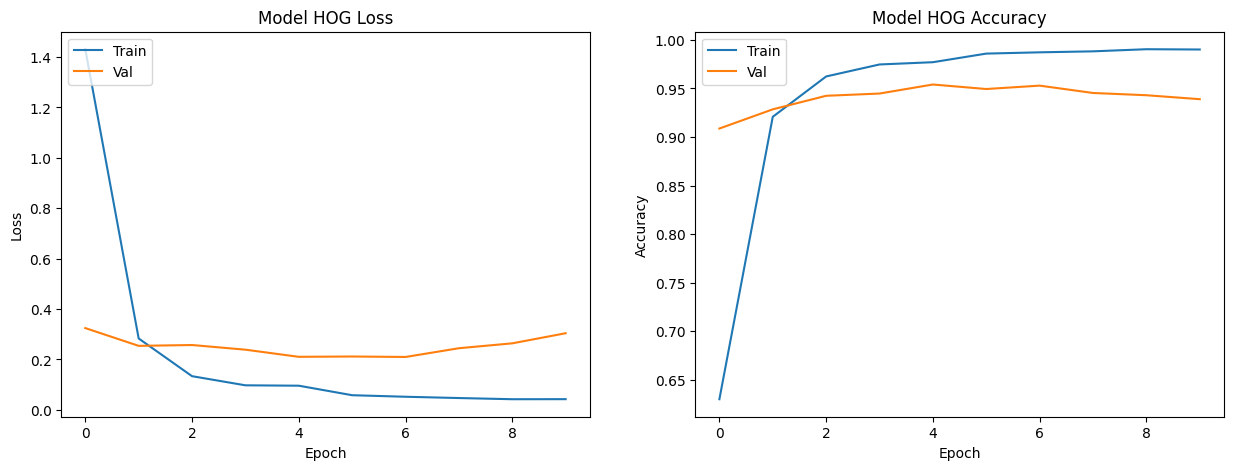

In [34]:
# define a function to plot the accuracy and loss for the model

def plot_accuracy_loss(history, name= "Model HOG"):

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(name + ' Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Val'], loc='upper left')

    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(name + ' Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Val'], loc='upper left')

    plt.show()

plot_accuracy_loss(history_hog)


In [97]:
# Create a confusion matrix as a 2D array.
def plot_confusion_matrix(title, y_test, y_prediction):
    label_names = [f"Class {i}" for i in range(43)]

    confusion_matrix = tf.math.confusion_matrix(y_test, y_prediction)
    plt.figure(figsize=(12, 10))

    color_map1 = ['lightgrey', '#ffff99', 'orange', '#7fc97f']
    color_map = ListedColormap(color_map1)

    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap=color_map,
        linewidths=0.5,
        square=True,
        cbar_kws={"label": "Count"},
        xticklabels=label_names,
        yticklabels=label_names,
        annot_kws={"size": 10},
    )
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title(title + " Confusion Matrix", fontsize=14)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=80, ha="right", fontsize=10)
    plt.yticks(rotation=0, fontsize=10)

    # Adjust layout to prevent cutoff of labels
    plt.tight_layout()

    # Add axis labels.
    # ax.set(xlabel="Predicted Label", ylabel="True Label")
    plt.show()
    return

Predicting ...
81/81 [==============================] - 1s 11ms/step

Accuracy on Test Set: 87.28682170542635


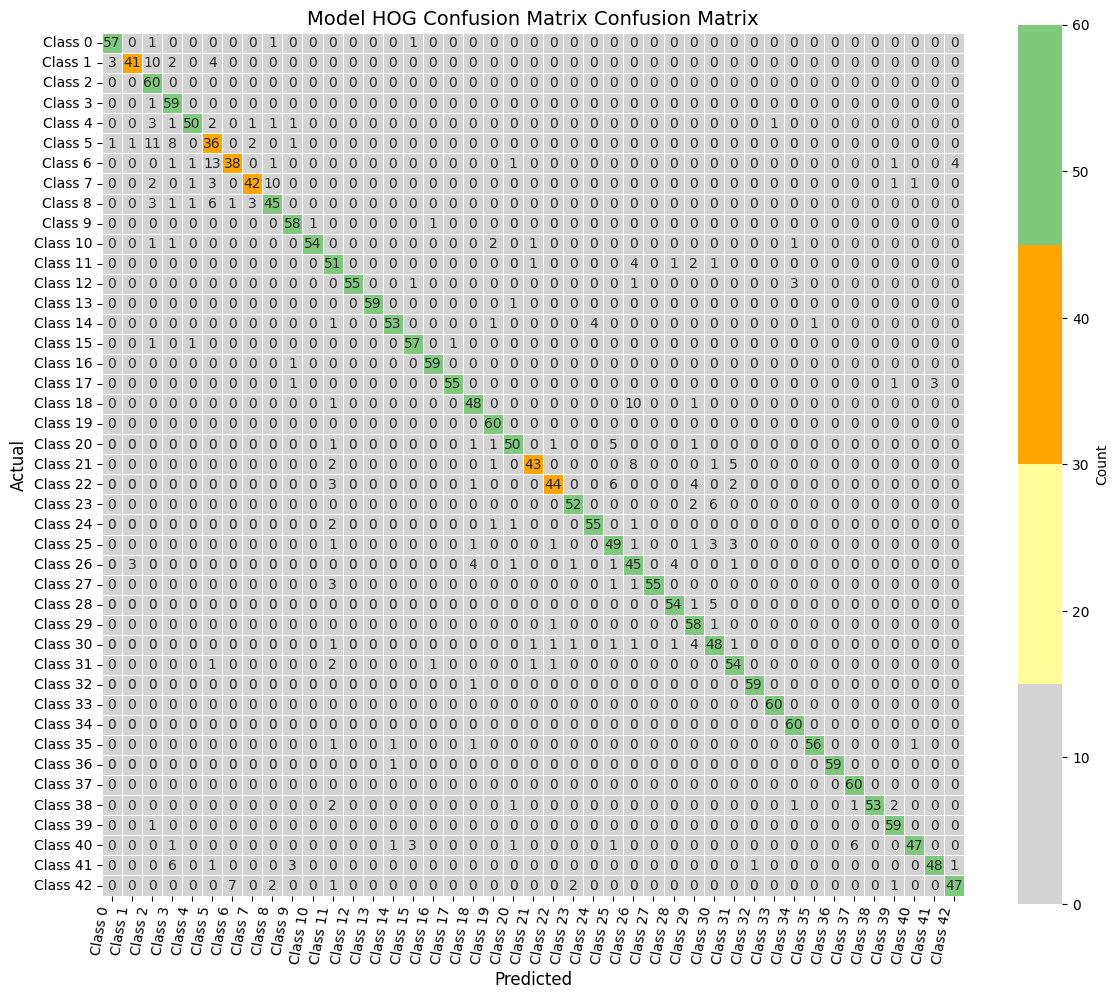

In [36]:
# comfusion matrix

# Predict
print('Predicting ...')
y_pred = model_hog.predict(X_test_hog)

y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
row = 0
for p in y_pred:
    clase = np.argmax(p)
    y_prediction[row] = clase
    row+=1

accuracy = accuracy_score(y_test_hog, y_prediction)
print("\nAccuracy on Test Set:", accuracy*100)

plot_confusion_matrix('Model HOG Confusion Matrix', y_test_hog, y_prediction)


In [37]:
# show the classification report
print("Classification Report")
print(classification_report(y_test_hog, y_prediction))



Classification Report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        60
           1       0.91      0.68      0.78        60
           2       0.64      1.00      0.78        60
           3       0.74      0.98      0.84        60
           4       0.93      0.83      0.88        60
           5       0.55      0.60      0.57        60
           6       0.83      0.63      0.72        60
           7       0.88      0.70      0.78        60
           8       0.75      0.75      0.75        60
           9       0.89      0.97      0.93        60
          10       0.98      0.90      0.94        60
          11       0.71      0.85      0.77        60
          12       1.00      0.92      0.96        60
          13       1.00      0.98      0.99        60
          14       0.95      0.88      0.91        60
          15       0.92      0.95      0.93        60
          16       0.97      0.98      0.98        60
     

In [38]:
# get the indices of misclassified images of class 26
misclassified_idx_26 = np.where((y_test_hog != y_prediction) & (y_test_hog == 26))[0]
print("Number of misclassified images of class 26: ", len(misclassified_idx_26))



Number of misclassified images of class 26:  15


##### Train a model using the Template features

Epoch 1/10


215/215 [==============================] - 15s 64ms/step - loss: 3.4841 - accuracy: 0.2709 - val_loss: 1.6834 - val_accuracy: 0.5326
Epoch 2/10
215/215 [==============================] - 14s 63ms/step - loss: 1.6744 - accuracy: 0.5728 - val_loss: 1.0697 - val_accuracy: 0.7134
Epoch 3/10
215/215 [==============================] - 14s 64ms/step - loss: 1.1913 - accuracy: 0.6830 - val_loss: 0.8963 - val_accuracy: 0.7645
Epoch 4/10
215/215 [==============================] - 14s 63ms/step - loss: 0.8868 - accuracy: 0.7648 - val_loss: 0.8461 - val_accuracy: 0.7826
Epoch 5/10
215/215 [==============================] - 14s 66ms/step - loss: 0.6652 - accuracy: 0.8233 - val_loss: 0.7084 - val_accuracy: 0.8192
Epoch 6/10
215/215 [==============================] - 14s 66ms/step - loss: 0.5472 - accuracy: 0.8551 - val_loss: 0.7490 - val_accuracy: 0.8192
Epoch 7/10
215/215 [==============================] - 14s 67ms/step - loss: 0.4526 - accuracy: 0.8811 - val_loss: 0.6574 - val_accuracy: 0.8419
Epo

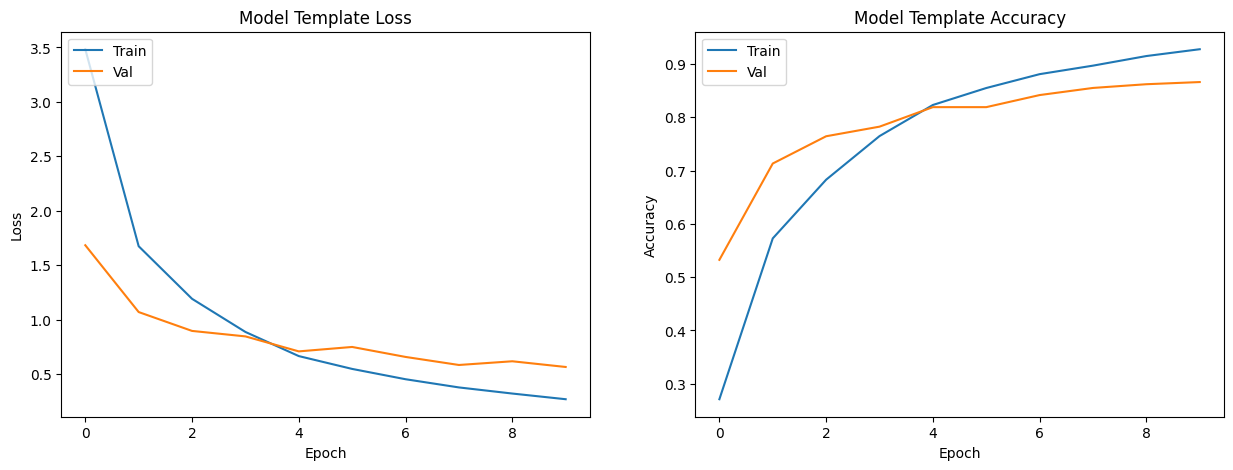

In [39]:
# train model to use the template features
history_temp = model_temp.fit(X_train_temp,
                    y_train_temp,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    # use X_val and y_val for validation data

                    validation_data=(X_val_temp, y_val_temp),

                    validation_split=0.2,
                    verbose=1)

plot_accuracy_loss(history_temp, "Model Template")

In [40]:
# The laste training and validation accuracy
print("The last training accuracy: ", history_temp.history['accuracy'][-1])
print("The last validation accuracy: ", history_temp.history['val_accuracy'][-1])

The last training accuracy:  0.9279069900512695
The last validation accuracy:  0.8662790656089783


In [41]:
# evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_temp = model_temp.evaluate(X_test_temp, y_test_temp, batch_size=32)
# display the results in percentage and 2 decimal points
results_temp = [round(x,4) for x in results_temp]
print("test loss, test acc:", results_temp)


Evaluate on test data
 1/81 [..............................] - ETA: 2s - loss: 0.1670 - accuracy: 0.9688

81/81 [==============================] - 1s 13ms/step - loss: 1.3526 - accuracy: 0.7422
test loss, test acc: [1.3526, 0.7422]


Predicting ...
81/81 [==============================] - 1s 13ms/step

Accuracy on Test Set: 74.2248062015504


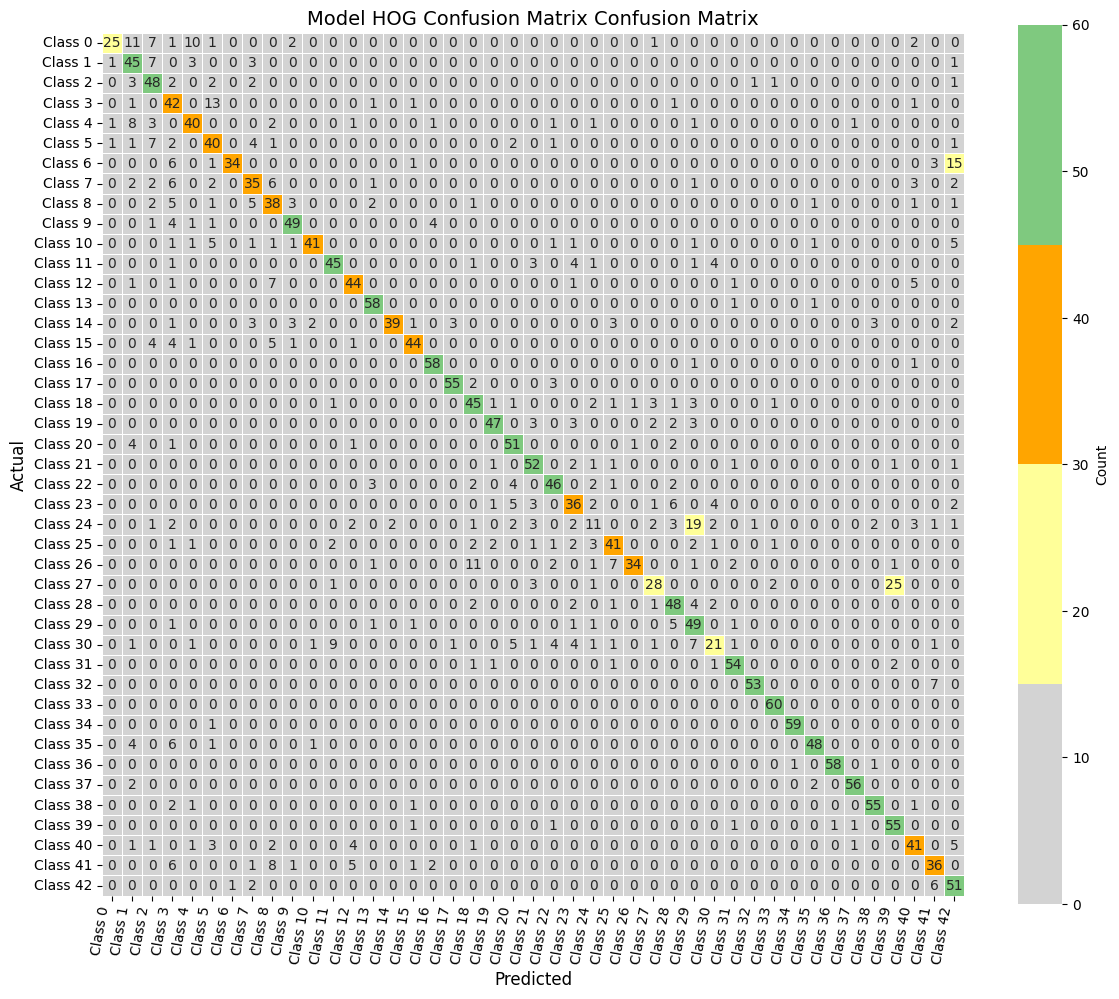

In [60]:
# comfusion matrix

# Predict
print('Predicting ...')
y_pred_temp = model_temp.predict(X_test_temp)

y_prediction_temp = np.full(shape=(y_pred_temp.shape[0]), fill_value=-1)
row = 0
for p in y_pred_temp:
    clase = np.argmax(p)
    y_prediction_temp[row] = clase
    row+=1

accuracy_temp = accuracy_score(y_test_temp, y_prediction_temp)
print("\nAccuracy on Test Set:", accuracy_temp*100)

plot_confusion_matrix('Model HOG Confusion Matrix', y_test_temp, y_prediction_temp)

In [62]:
# show the classification report
print("Classification Report")
print(classification_report(y_test_temp, y_prediction_temp))

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.42      0.57        60
           1       0.54      0.75      0.63        60
           2       0.58      0.80      0.67        60
           3       0.44      0.70      0.54        60
           4       0.67      0.67      0.67        60
           5       0.56      0.67      0.61        60
           6       0.97      0.57      0.72        60
           7       0.62      0.58      0.60        60
           8       0.54      0.63      0.58        60
           9       0.82      0.82      0.82        60
          10       0.91      0.68      0.78        60
          11       0.78      0.75      0.76        60
          12       0.76      0.73      0.75        60
          13       0.87      0.97      0.91        60
          14       0.95      0.65      0.77        60
          15       0.86      0.73      0.79        60
          16       0.89      0.97      0.93        60
     

In [69]:
X_val_hue.shape

(1720, 180)

In [70]:
y_val_hue.shape

(1720,)

##### Train a model using the hue features

In [43]:
# evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_ttl = model_ttl.evaluate(X_test_ttl, y_test_ttl, batch_size=32)
# display the results in percentage and 2 decimal points
results_ttl = [round(x,4) for x in results_ttl]
print("test loss, test acc:", results_ttl)

Evaluate on test data
81/81 [==============================] - 2s 27ms/step - loss: 3.1784 - accuracy: 0.1806
test loss, test acc: [3.1784, 0.1806]


##### Train a model using the hog + template features

Epoch 1/10
215/215 [==============================] - 22s 99ms/step - loss: 3.3934 - accuracy: 0.1868 - val_loss: 2.7213 - val_accuracy: 0.2541
Epoch 2/10
215/215 [==============================] - 21s 98ms/step - loss: 2.5423 - accuracy: 0.3190 - val_loss: 2.1547 - val_accuracy: 0.4017
Epoch 3/10
215/215 [==============================] - 22s 102ms/step - loss: 1.9728 - accuracy: 0.4487 - val_loss: 1.7902 - val_accuracy: 0.4674
Epoch 4/10
215/215 [==============================] - 23s 106ms/step - loss: 1.6945 - accuracy: 0.4895 - val_loss: 1.6484 - val_accuracy: 0.4901
Epoch 5/10
215/215 [==============================] - 22s 104ms/step - loss: 1.4455 - accuracy: 0.5297 - val_loss: 1.4437 - val_accuracy: 0.5797
Epoch 6/10
215/215 [==============================] - 22s 102ms/step - loss: 1.2328 - accuracy: 0.5842 - val_loss: 1.2114 - val_accuracy: 0.5930
Epoch 7/10
215/215 [==============================] - 22s 105ms/step - loss: 1.0148 - accuracy: 0.6513 - val_loss: 1.0355 - val_accu

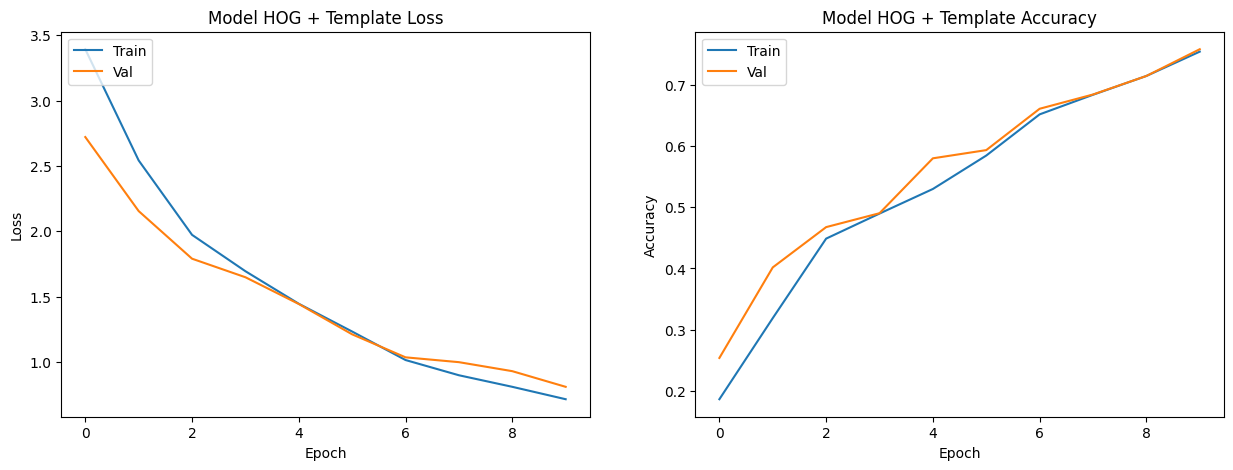

In [44]:
# train a model for hog and template features
EPOCHS = 10

history_hog_temp = model_hog_temp.fit(X_train_hog_temp,
                    y_train_hog_temp,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_data=(X_val_hog_temp, y_val_hog_temp),
                    # validation_split=0.2,
                    verbose=1)

plot_accuracy_loss(history_hog_temp, "Model HOG + Template")

In [45]:
# evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_hog_temp = model_hog_temp.evaluate(X_test_hog_temp, y_test_hog_temp, batch_size=32)
# display the results in percentage and 2 decimal points
results_hog_temp = [round(x,4) for x in results_hog_temp]
print("test loss, test acc:", results_hog_temp)


Evaluate on test data
 1/81 [..............................] - ETA: 3s - loss: 0.2780 - accuracy: 0.9688

81/81 [==============================] - 1s 17ms/step - loss: 1.1884 - accuracy: 0.6818
test loss, test acc: [1.1884, 0.6818]


###  Efficiency vs Accuracy Analysis

In [46]:
# define a model to iterate over the different parameters

def create_cnn_model_2(filters=[6,16], kernel_size=[21,5], strides=1, padding='same',               
                    input_shape= ms_input_shape_hog,
                    learn_rate=0.001,
                    dense_layer=[120, 84],
                    dropout=0.5,                    
                    ):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)  
    print("Creating model with parameters: ")
    print("filters: ", filters, "kernel_size: ", kernel_size, "strides: ", strides, "padding: ", padding, "input_shape: ", input_shape, "learn_rate: ", learn_rate, "dense_layer: ", dense_layer, "dropout: ", dropout) 
        
    model = Sequential()
    model.add(Conv1D(filters=filters[0], kernel_size=kernel_size[0], strides=strides, padding=padding, activation='relu', 
                    input_shape= input_shape,kernel_initializer=keras.initializers.he_normal()))
    model.add(BatchNormalization()) 
    model.add(MaxPooling1D(pool_size=2, strides=2, padding=padding))
    model.add(Conv1D(filters=filters[1], kernel_size=kernel_size[1], strides=1, padding=padding,activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding=padding))
    model.add(Flatten())   
    model.add(Dense(dense_layer[0], activation='relu'))
    model.add(Dense(dense_layer[1]))
    model.add(Dropout(rate=dropout, name='Dropout'))

    model.add(Dense(43, activation='softmax', name='Output'))
    model.compile(optimizer=Adam(learning_rate=learn_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# define a function to train the model and return the accuracy and loss

In [47]:
# train the model using different parameters and time the training

import time

def train_model(X_train, y_train, X_val, y_val, X_test, y_test, model_name, epochs=10, batch_size=32, callbacks_list=callbacks_list):
    start_time = time.time()
    history = model_name.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callbacks_list,
                    validation_data=(X_val, y_val),
                    verbose=0)
    end_time = time.time()
    train_time = end_time - start_time
    print("Time taken to train the model: ", train_time)
    # get the best result of the model
    best_train_acc = np.max(history.history['accuracy'])
    print("Best train accuracy of model: %.2f%%" % (best_train_acc*100))
    best_val_acc = np.max(history.history['val_accuracy'])
    last_train_acc = history.history['accuracy'][-1]
    last_val_acc = history.history['val_accuracy'][-1]
    print("Best validation accuracy of model: %.2f%%" % (best_val_acc*100))
    print("The last training accuracy: ", last_train_acc)
    print("The last validation accuracy: ", last_val_acc)

    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    results = model_name.evaluate(X_test, y_test, batch_size=32)
    # display the results in percentage and 2 decimal points
    results = [round(x,4) for x in results]
    test_acc = results[1]
    print("test loss, test acc:", results)
    return history, last_train_acc, last_val_acc, test_acc, train_time, epochs

In [48]:
dropout = 0.5
dense = [84, 64]
filters = [6,16]
kernel_size = [15, 5]
EPOCHS = 1
model_test = create_cnn_model_2(filters=filters, kernel_size=kernel_size, dense_layer=dense, dropout=dropout, input_shape=ms_input_shape_hog_temp)
history, last_train_acc, last_val_acc, test_acc, train_time, epochs = train_model(X_train_hog_temp, y_train_hog_temp, X_val_hog_temp, y_val_hog_temp, X_test_hog_temp, y_test_hog_temp, model_name=model_test, epochs=EPOCHS)

Creating model with parameters: 
filters:  [6, 16] kernel_size:  [15, 5] strides:  1 padding:  same input_shape:  (6399, 1) learn_rate:  0.001 dense_layer:  [84, 64] dropout:  0.5


Time taken to train the model:  21.353680849075317
Best train accuracy of model: 13.47%
Best validation accuracy of model: 19.48%
The last training accuracy:  0.13473837077617645
The last validation accuracy:  0.19476744532585144
Evaluate on test data
81/81 [==============================] - 1s 17ms/step - loss: 3.1597 - accuracy: 0.1938
test loss, test acc: [3.1597, 0.1938]


In [49]:
# create a dataframe to store the results of the different models
columns = ['Model', 'Epochs', 'Filter_Size', 'Kernel_Size', 'Dense_Layer', 'Dropout', 'Train_Accuracy', 'Val_Accuracy', 'Test_Accuracy', 'Train_Time' ]
results_df = pd.DataFrame(columns=columns)
results_df_h2 = pd.DataFrame(columns=columns)
results_df

,Model,Epochs,Filter_Size,Kernel_Size,Dense_Layer,Dropout,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_Time


In [50]:


# ITERATE OVER THE PARAMETERS AND TRAIN THE MODEL
EPOCHS = [10]
filters = [[6,16], [12, 16]]
kernel_size = [21,5]
dense = [[120, 84], [84, 64]]
dropout = [0.5, 0.3]

count = 0
for epoch in EPOCHS:
    for filter in filters:
        for dense_layer in dense:
            for drop in dropout:
                print("#############################################################################################################")
                print("Epochs: ", epoch, "filters: ", filter, "dense_layer: ", dense_layer, "dropout: ", drop)
                model = create_cnn_model_2(filters=filter, kernel_size=kernel_size, dense_layer=dense_layer, dropout=drop, input_shape=ms_input_shape_hog_temp)
                history, last_train_acc, last_val_acc, test_acc, train_time, epochs = train_model(X_train_hog_temp, y_train_hog_temp, X_val_hog_temp, y_val_hog_temp, X_test_hog_temp, y_test_hog_temp, model_name=model, epochs=epoch)
                results_df.loc[count] = ['Model HOG + Template', epoch, filter, kernel_size, dense_layer, drop, last_train_acc, last_val_acc, test_acc, train_time]
                count += 1
                print("#############################################################################################################")

#############################################################################################################
Epochs:  10 filters:  [6, 16] dense_layer:  [120, 84] dropout:  0.5
Creating model with parameters: 
filters:  [6, 16] kernel_size:  [21, 5] strides:  1 padding:  same input_shape:  (6399, 1) learn_rate:  0.001 dense_layer:  [120, 84] dropout:  0.5


Time taken to train the model:  87.28248238563538
Best train accuracy of model: 12.41%
Best validation accuracy of model: 12.09%
The last training accuracy:  0.11874999850988388
The last validation accuracy:  0.1197674423456192
Evaluate on test data
81/81 [==============================] - 1s 18ms/step - loss: 3.3231 - accuracy: 0.1326
test loss, test acc: [3.3231, 0.1326]
#############################################################################################################
#############################################################################################################
Epochs:  10 filters:  [6, 16] dense_layer:  [120, 84] dropout:  0.3
Creating model with parameters: 
filters:  [6, 16] kernel_size:  [21, 5] strides:  1 padding:  same input_shape:  (6399, 1) learn_rate:  0.001 dense_layer:  [120, 84] dropout:  0.3
Time taken to train the model:  220.72574377059937
Best train accuracy of model: 98.84%
Best validation accuracy of model: 94.36%
The last training accurac

In [51]:
# ITERATE OVER THE PARAMETERS AND TRAIN THE MODEL
EPOCHS = [20]
filters = [[6,16], [12, 16]]
kernel_size = [21,5]
dense = [[120, 84], [84, 64]]
dropout = [0.5, 0.3]

count = 0
for epoch in EPOCHS:
    for filter in filters:
        for dense_layer in dense:
            for drop in dropout:
                print("#############################################################################################################")
                print("Epochs: ", epoch, "filters: ", filter, "dense_layer: ", dense_layer, "dropout: ", drop)
                model = create_cnn_model_2(filters=filter, kernel_size=kernel_size, dense_layer=dense_layer, dropout=drop, input_shape=ms_input_shape_hog_temp)
                history, last_train_acc, last_val_acc, test_acc, train_time, epochs = train_model(X_train_hog_temp, y_train_hog_temp, X_val_hog_temp, y_val_hog_temp, X_test_hog_temp, y_test_hog_temp, model_name=model, epochs=epoch)
                results_df_h2.loc[count] = ['Model HOG + Template', epoch, filter, kernel_size, dense_layer, drop, last_train_acc, last_val_acc, test_acc, train_time]
                count += 1
                print("#############################################################################################################")

#############################################################################################################
Epochs:  20 filters:  [6, 16] dense_layer:  [120, 84] dropout:  0.5
Creating model with parameters: 
filters:  [6, 16] kernel_size:  [21, 5] strides:  1 padding:  same input_shape:  (6399, 1) learn_rate:  0.001 dense_layer:  [120, 84] dropout:  0.5


Time taken to train the model:  431.2134668827057
Best train accuracy of model: 98.47%
Best validation accuracy of model: 93.55%
The last training accuracy:  0.9847383499145508
The last validation accuracy:  0.9354650974273682
Evaluate on test data
81/81 [==============================] - 2s 18ms/step - loss: 0.8487 - accuracy: 0.8612
test loss, test acc: [0.8487, 0.8612]
#############################################################################################################
#############################################################################################################
Epochs:  20 filters:  [6, 16] dense_layer:  [120, 84] dropout:  0.3
Creating model with parameters: 
filters:  [6, 16] kernel_size:  [21, 5] strides:  1 padding:  same input_shape:  (6399, 1) learn_rate:  0.001 dense_layer:  [120, 84] dropout:  0.3
Time taken to train the model:  424.5715889930725
Best train accuracy of model: 98.95%
Best validation accuracy of model: 92.97%
The last training accuracy:

In [52]:
results_df_combined = pd.concat([results_df, results_df_h2])
results_df_combined

,Model,Epochs,Filter_Size,Kernel_Size,Dense_Layer,Dropout,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_Time
0,Model HOG + Template,10,"[6, 16]","[21, 5]","[120, 84]",0.5,0.118750,0.119767,0.1326,87.282482
1,Model HOG + Template,10,"[6, 16]","[21, 5]","[120, 84]",0.3,0.988372,0.933721,0.8578,220.725744
2,Model HOG + Template,10,"[6, 16]","[21, 5]","[84, 64]",0.5,0.251744,0.211628,0.2198,205.844563
3,Model HOG + Template,10,"[6, 16]","[21, 5]","[84, 64]",0.3,0.777180,0.767442,0.7198,201.338479
4,Model HOG + Template,10,"[12, 16]","[21, 5]","[120, 84]",0.5,0.255378,0.242442,0.2473,260.390585
5,Model HOG + Template,10,"[12, 16]","[21, 5]","[120, 84]",0.3,0.983721,0.926163,0.8422,262.970238
6,Model HOG + Template,10,"[12, 16]","[21, 5]","[84, 64]",0.5,0.253779,0.254651,0.2539,251.853055
7,Model HOG + Template,10,"[12, 16]","[21, 5]","[84, 64]",0.3,0.980959,0.926163,0.8178,253.439452
0,Model HOG + Template,20,"[6, 16]","[21, 5]","[120, 84]",0.5,0.984738,0.935465,0.8612,431.213467
1,Model HOG + Template,20,"[6, 16]","[21, 5]","[120, 84]",0.3,0.989535,0.929651,0.8523,424.571589


In [53]:
# save the results to csv
results_df_combined.to_csv(Path("data/results_hog_temp_combined.csv"), index=False)



In [54]:
#create another dataframe to store the results of the different models
results_hog_df = pd.DataFrame(columns=columns)     # for 10 epochs

# use columns to rename the columns of the dataframe
results_hog_df2 = pd.DataFrame(columns=columns)    # for 20 epochs

In [55]:

# ITERATE OVER THE PARAMETERS AND TRAIN THE MODEL
EPOCHS = [10]
filters = [[6,16], [12, 16]]
kernel_size = [21,5]
dense = [[120, 84], [84, 64]]
dropout = [0.5, 0.3]

count = 0
for epoch in EPOCHS:
    for filter in filters:
        for dense_layer in dense:
            for drop in dropout:
                print("#############################################################################################################")
                print("Epochs: ", epoch, "filters: ", filter, "dense_layer: ", dense_layer, "dropout: ", drop)
                model = create_cnn_model_2(filters=filter, kernel_size=kernel_size, dense_layer=dense_layer, dropout=drop, input_shape=ms_input_shape_hog)
                history, last_train_acc, last_val_acc, test_acc, train_time, epochs = train_model(X_train_hog, y_train_hog, X_val_hog, y_val_hog, X_test_hog, y_test_hog, model_name=model, epochs=epoch)
                results_hog_df.loc[count] = ['Model HOG', epoch, filter, kernel_size, dense_layer, drop, last_train_acc, last_val_acc, test_acc, train_time]
                count += 1
                print("#############################################################################################################")

#############################################################################################################
Epochs:  10 filters:  [6, 16] dense_layer:  [120, 84] dropout:  0.5
Creating model with parameters: 
filters:  [6, 16] kernel_size:  [21, 5] strides:  1 padding:  same input_shape:  (2916, 1) learn_rate:  0.001 dense_layer:  [120, 84] dropout:  0.5


Time taken to train the model:  109.91217136383057
Best train accuracy of model: 99.22%
Best validation accuracy of model: 95.47%
The last training accuracy:  0.9899709224700928
The last validation accuracy:  0.9406976699829102
Evaluate on test data
81/81 [==============================] - 1s 12ms/step - loss: 0.8439 - accuracy: 0.8756
test loss, test acc: [0.8439, 0.8756]
#############################################################################################################
#############################################################################################################
Epochs:  10 filters:  [6, 16] dense_layer:  [120, 84] dropout:  0.3
Creating model with parameters: 
filters:  [6, 16] kernel_size:  [21, 5] strides:  1 padding:  same input_shape:  (2916, 1) learn_rate:  0.001 dense_layer:  [120, 84] dropout:  0.3
Time taken to train the model:  106.80530905723572
Best train accuracy of model: 99.30%
Best validation accuracy of model: 94.71%
The last training accurac

In [56]:
results_hog_df

,Model,Epochs,Filter_Size,Kernel_Size,Dense_Layer,Dropout,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_Time
0,Model HOG,10,"[6, 16]","[21, 5]","[120, 84]",0.5,0.989971,0.940698,0.8756,109.912171
1,Model HOG,10,"[6, 16]","[21, 5]","[120, 84]",0.3,0.985756,0.927326,0.8640,106.805309
2,Model HOG,10,"[6, 16]","[21, 5]","[84, 64]",0.5,0.982122,0.946512,0.8779,90.649574
3,Model HOG,10,"[6, 16]","[21, 5]","[84, 64]",0.3,0.992297,0.950000,0.8849,79.952280
4,Model HOG,10,"[12, 16]","[21, 5]","[120, 84]",0.5,0.990843,0.937209,0.8713,144.788652
5,Model HOG,10,"[12, 16]","[21, 5]","[120, 84]",0.3,0.993314,0.928488,0.8640,114.789871
6,Model HOG,10,"[12, 16]","[21, 5]","[84, 64]",0.5,0.986773,0.935465,0.8674,125.162019
7,Model HOG,10,"[12, 16]","[21, 5]","[84, 64]",0.3,0.984884,0.944767,0.8655,110.886343


In [57]:
EPOCHS = [20]
filters = [[6,16], [12, 16]]
kernel_size = [21,5]
dense = [[120, 84], [84, 64]]
dropout = [0.5, 0.3]

count = 0
for epoch in EPOCHS:
    for filter in filters:
        for dense_layer in dense:
            for drop in dropout:
                print("#############################################################################################################")
                print("Epochs: ", epoch, "filters: ", filter, "dense_layer: ", dense_layer, "dropout: ", drop)
                model = create_cnn_model_2(filters=filter, kernel_size=kernel_size, dense_layer=dense_layer, dropout=drop, input_shape=ms_input_shape_hog)
                history, last_train_acc, last_val_acc, test_acc, train_time, epochs = train_model(X_train_hog, y_train_hog, X_val_hog, y_val_hog, X_test_hog, y_test_hog, model_name=model, epochs=epoch)
                results_hog_df2.loc[count] = ['Model HOG', epoch, filter, kernel_size, dense_layer, drop, last_train_acc, last_val_acc, test_acc, train_time]
                count += 1
                print("#############################################################################################################")

#############################################################################################################
Epochs:  20 filters:  [6, 16] dense_layer:  [120, 84] dropout:  0.5
Creating model with parameters: 
filters:  [6, 16] kernel_size:  [21, 5] strides:  1 padding:  same input_shape:  (2916, 1) learn_rate:  0.001 dense_layer:  [120, 84] dropout:  0.5


Time taken to train the model:  105.68283224105835
Best train accuracy of model: 99.11%
Best validation accuracy of model: 95.12%
The last training accuracy:  0.9892441630363464
The last validation accuracy:  0.9430232644081116
Evaluate on test data
81/81 [==============================] - 1s 14ms/step - loss: 0.6143 - accuracy: 0.8787
test loss, test acc: [0.6143, 0.8787]
#############################################################################################################
#############################################################################################################
Epochs:  20 filters:  [6, 16] dense_layer:  [120, 84] dropout:  0.3
Creating model with parameters: 
filters:  [6, 16] kernel_size:  [21, 5] strides:  1 padding:  same input_shape:  (2916, 1) learn_rate:  0.001 dense_layer:  [120, 84] dropout:  0.3
Time taken to train the model:  85.2323808670044
Best train accuracy of model: 98.95%
Best validation accuracy of model: 95.52%
The last training accuracy:

In [58]:
# combine results_hog_df and results_hog_df2
results_hog_df_combined = pd.concat([results_hog_df, results_hog_df2])
results_hog_df_combined

,Model,Epochs,Filter_Size,Kernel_Size,Dense_Layer,Dropout,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_Time
0,Model HOG,10,"[6, 16]","[21, 5]","[120, 84]",0.5,0.989971,0.940698,0.8756,109.912171
1,Model HOG,10,"[6, 16]","[21, 5]","[120, 84]",0.3,0.985756,0.927326,0.8640,106.805309
2,Model HOG,10,"[6, 16]","[21, 5]","[84, 64]",0.5,0.982122,0.946512,0.8779,90.649574
3,Model HOG,10,"[6, 16]","[21, 5]","[84, 64]",0.3,0.992297,0.950000,0.8849,79.952280
4,Model HOG,10,"[12, 16]","[21, 5]","[120, 84]",0.5,0.990843,0.937209,0.8713,144.788652
5,Model HOG,10,"[12, 16]","[21, 5]","[120, 84]",0.3,0.993314,0.928488,0.8640,114.789871
6,Model HOG,10,"[12, 16]","[21, 5]","[84, 64]",0.5,0.986773,0.935465,0.8674,125.162019
7,Model HOG,10,"[12, 16]","[21, 5]","[84, 64]",0.3,0.984884,0.944767,0.8655,110.886343
0,Model HOG,20,"[6, 16]","[21, 5]","[120, 84]",0.5,0.989244,0.943023,0.8787,105.682832
1,Model HOG,20,"[6, 16]","[21, 5]","[120, 84]",0.3,0.985320,0.955233,0.8771,85.232381


In [59]:
# save the results to csv
results_hog_df_combined.to_csv(Path("data/results_hog_comb.csv"), index=False)
